In [6]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


In [ ]:
importlib.reload(pack_ga)
fastMode = False
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([10])
runner.plot_fitness_predictors = True
runner.plot_diversity_matrix = True
runner.n_generations = 300
if fastMode:
    runner.initializer.jiggler.duration_compact /= 10
    runner.initializer.jiggler.plot_interval = None
    runner.initializer.jiggler.n_rounds = 1    
    runner.rough_relaxers[0].n_iterations= 0
    runner.fine_relaxers = []
    runner.n_generations = 5
    runner.population_size = 100
    runner.selection_size = [1,2,5,10]
    kgs.debugging_mode = 2
kgs.profiling=False
runner.run()

stop final relax at some point


[0.03751056] [0.03751056] 1.9263016
[0.03751056] [0.03789815] 1.9428455
[0.00015166]
[2.4986344e-10]
[0.0380168] 1.9497898 0.38016802


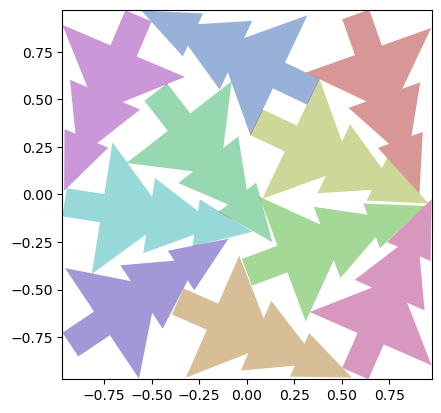

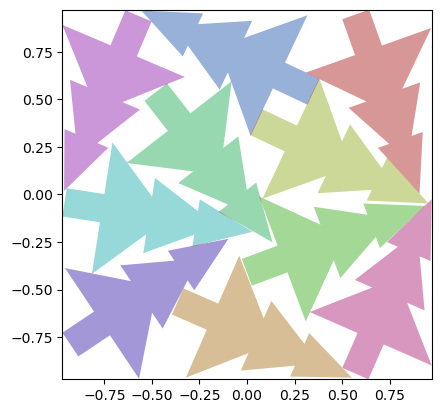

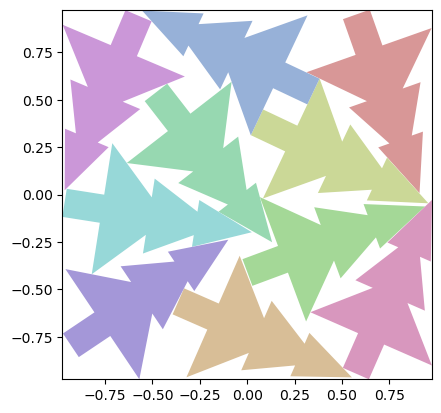

In [ ]:
id = np.argmin(runner.populations[0].fitness)
sol_best =  copy.deepcopy(runner.populations[0])
sol_best.select_ids([id])
print(sol_best.fitness, runner.fitness_cost.compute_cost_allocate(sol_best.configuration)[0].get(), sol_best.configuration.h[0,0])
tree_list = kgs.TreeList()
tree_list.xyt = sol_best.configuration.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
sol_best.configuration.snap()
tree_list = kgs.TreeList()
tree_list.xyt = sol_best.configuration.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
print(sol_best.fitness, runner.fitness_cost.compute_cost_allocate(sol_best.configuration)[0].get(), sol_best.configuration.h[0,0])
cost0 = copy.deepcopy(runner.fine_relaxers[0].cost)
cost0.costs[0].scaling = 0.
print(cost0.compute_cost_allocate(sol_best.configuration)[0].get())
relaxer = copy.deepcopy(runner.fine_relaxers[0])
relaxer.cost = cost0
relaxer.dt/=10
relaxer.n_iterations *= 3
conf_best = relaxer.run_simulation(sol_best.configuration)
tree_list = kgs.TreeList()
tree_list.xyt = conf_best.xyt[0].get()
pack_vis.visualize_tree_list(tree_list)
print(cost0.compute_cost_allocate(conf_best)[0].get())
print(runner.fitness_cost.compute_cost_allocate(conf_best)[0].get(), conf_best.h[0,0], conf_best.h[0,0]**2/conf_best.N_trees)